<a href="https://colab.research.google.com/github/marceloccs/deep_learning_pos_ai/blob/main/Trilha_8_Uso_de_PyThorch_como_hyper_parametros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Nome:** Marcelo Custodio Cruz Silva

##**Matricula:** 92123341

---

##**Curso:** Inteligencia Artificial

##**Turma:** B

*Link do arquivo no google colabs: https://colab.research.google.com/drive/1cKC02LtR1lDJq5QeEuKpL6N7M3w33lQE?usp=sharing*

*Link do arquivo no github: https://github.com/marceloccs/deep_learning_pos_ai/blob/main/Trilha_8_Uso_de_PyThorch_como_hyper_parametros.ipynb* 

#Trilha 8: Tarefa

Nesta tarefa você fará o ajuste automático dos hiperparâmetros do modelo TensorFlow que você desenvolveu na atividade da Trilha 4. O resultado do seu modelo deve ser acima de 0.8 de acuracidade sobre o conjunto de teste (0.3 dos dados de treinamento). Mostre sua seleção de valores de hiperparâmetros e os resultados apresentados ao final indicando a diferença obtida com relação ao modelo original.   

 

Se preferir, você pode fazer o tunning dos hiperparâmetros em PyTorch empregando a atividade da Trilha 6 como modelo inicial. 

 

Ao final, apresente as suas conclusões. 



Enviar a atividade em .pdf juntamente com o endereço do Python notebook 100% executável. 

##Preparos iniciais do modelo

###Imports para dependencias necessarias ao decorrer do modelo.

In [1]:
!pip install -q -U keras-tuner

In [2]:
#Manipulação de dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#Tnsorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#Keras Tuner
import kerastuner as kt
#Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
#Auxiliar para leitura e print de dados
from IPython.display import display
import math

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  # Remove the CWD from sys.path while we load stuff.


###Leitura do arquivo para predição de cogumelos.

*Modelo de classificação binária para identificação se o cogumelo, pelas suas características físicas, é comestível ou venenoso.*

**Link Kaggle:** https://archive.ics.uci.edu/ml/datasets/Mushroom

**Link Github:** https://raw.githubusercontent.com/marceloccs/pos-ai-files/main/Trilha%204%20Uso%20de%20tensores%20com%20TenserFlow/agaricus-lepiota.data

A seguir é utilizado um dataset contendo diversas especies de cogumelos, as características vão ser utilizadas para definir se o cogumelo é venenoso ou comestível. Para realizar esse predição é utilizado o modelo de classificação binária.

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/marceloccs/pos-ai-files/main/Trilha%204%20Uso%20de%20tensores%20com%20TenserFlow/agaricus-lepiota.data')
df = df.dropna()
display(df.head())

,classe,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,stalk_shape,stalk_root,stalk_surface_above_ring,stalk_surface_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_type,veil_color,ring_number,ring_type,spore_print_color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g


###Informações de atributos: 



     1. classes: comestíveis = e, venenosos = p
     2. forma de capa: sino = b, cônico = c, convexo = x, plano = f,knobbed = k, sunken = s
     3. superfície da capa: fibrosa = f, ranhuras = g, escamosa = y, lisa = s
     4. cor da tampa: marrom = n, amarelo-claro = b, canela = c, cinza = g, verde = r, rosa = p, roxo = u, vermelho = e, branco = w, amarelo = y
     5. hematomas ?: hematomas = t, não = f
     6. odor: amêndoa = a, anis = l, creosoto = c, peixe = y, fétido = f, mofo = m, nenhum = n, picante = p, picante = s 
     7. anexo de brânquia: anexado = a, descendente = d, livre = f, entalhado = n
     8. espaçamento entre guelras: próximo = c, lotado = w, distante = d
     9. tamanho da guelra: largo = b, estreito = n
     10. cor das guelras: preto = k, marrom = n, amarelo-claro = b, chocolate = h, cinza = g, verde = r, laranja = o, rosa = p, roxo = u, vermelho = e, branco = w, amarelo = y
     11. formato de haste: ampliação = e, afilamento = t
     12. raiz do caule: bulboso = b, clube = c, xícara = u, igual = e, rizomorfos = z, enraizado = r, ausente =?
     13. superfície da haste acima do anel: fibroso = f, escamoso = y, sedoso = k, liso = s
     14. superfície do caule abaixo do anel: fibroso = f, escamoso = y, sedoso = k, liso = s
     15. haste-cor-acima do anel: marrom = n, amarelo-claro = b, canela = c, cinza = g, laranja = o, rosa = p, vermelho = e, branco = w, amarelo = y
     16. cor-do-caule abaixo do anel: marrom = n, amarelo-claro = b, canela = c, cinza = g, laranja = o, rosa = p, vermelho = e, branco = w, amarelo = y
     17. tipo de véu: parcial = p, universal = u 
     18. cor do véu: marrom = n, laranja = o, branco = w, amarelo = y
     19. número do anel: nenhum = n, um = o, dois = t 19. tipo de anel: teia de aranha = c, evanescente = e, alargamento = f, grande = l, nenhum = n, pendente = p, revestimento = s, zona = z
     20. spore-print-color: black = k, brown = n, buff = b, chocolate = h, green = r, laranja = o, roxo = u, branco = w, amarelo = y
     21. população: abundante = a, agrupado = c, numeroso = n, espalhado = s, vários = v, solitário = y
     22. habitat: gramíneas = g, folhas = l, prados = m, caminhos = p, urbano = u, desperdício = w, madeiras = d

###Contagem de cogumelos por classe:

In [4]:
dfCount = df['classe'].value_counts()
display(dfCount)

e    4208
p    3916
Name: classe, dtype: int64

####Função Auxiliar para leitura descretização

*Como o modelo é para classificação binária, é necessario valores numéricos no modelo*
 
A função abaixo faz um Labbel enconder por valores na coluna, realizando uma discretização de valores.

In [5]:
def dataframeEncoding(dataframe):
    le = LabelEncoder()
    for i in range(len(dataframe.columns)):
        le.fit(dataframe.iloc[:,i])
        dataframe.iloc[:,i]  = le.transform(dataframe.iloc[:,i])
    return dataframe

In [6]:
df = dataframeEncoding(df)
display(df.head())

,classe,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,stalk_shape,stalk_root,stalk_surface_above_ring,stalk_surface_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_type,veil_color,ring_number,ring_type,spore_print_color,population,habitat
0,1,5,2,4,1,6,1,0,1,4,0,3,2,2,7,7,0,2,1,4,2,3,5
1,0,5,2,9,1,0,1,0,0,4,0,2,2,2,7,7,0,2,1,4,3,2,1
2,0,0,2,8,1,3,1,0,0,5,0,2,2,2,7,7,0,2,1,4,3,2,3
3,1,5,3,8,1,6,1,0,1,5,0,3,2,2,7,7,0,2,1,4,2,3,5
4,0,5,2,3,0,5,1,1,0,4,1,3,2,2,7,7,0,2,1,0,3,0,1


##Inicio do modelo, treinamento e resultado  

###Separação de modelos de teste e de treinamento

*Separando os grupos de teste e treino, com o tamanho de teste de 30% (ou 0.3) do modelo todo*

In [7]:
dfClassificacao = df.copy()
X = dfClassificacao.drop('classe', axis=1)
y = dfClassificacao[['classe']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=6)
display(X_train.head())
display(y_train.head())

,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,stalk_shape,stalk_root,stalk_surface_above_ring,stalk_surface_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_type,veil_color,ring_number,ring_type,spore_print_color,population,habitat
716,0,2,8,1,3,1,0,0,4,0,2,2,2,7,7,0,2,1,4,3,3,3
36,4,0,3,0,5,1,0,1,4,0,3,2,2,7,7,0,2,1,4,2,4,5
336,5,3,4,1,0,1,0,0,10,0,4,2,3,7,7,0,2,1,4,2,5,1
8084,0,0,3,0,5,1,1,0,7,0,0,1,1,7,7,0,2,2,4,7,3,1
960,5,0,4,0,5,1,1,0,5,1,3,0,0,7,7,0,2,1,0,2,0,1


,classe
716,0
36,0
336,0
8084,0
960,0


###Modelo de aprendizado binario

**Abaixo o modelo criado possui 4 camadas**

Como usado o hyperparametro para decidir o numero de camadas, não temos como saber quantas camadas são criadas, mas sabemos que eram ser criadas pelo menos:

1.   Camada com sigmoid, para trabalhar com valores de classes binaria e valores numéricos. *Porem com o numero de unidades definido pelo tuner*
2.   Um numero determinado pelo tuner de camadas lineares com a função de ativação ReLu.
3.   Um numero determinado pelo tuner de camadas de Dropout.
4.   Camada de saída com sigmoid novamente. *Criado com o valor de entrada de neurônios com o a quantidade de colunas do conjunto de treinamento com os valores de classe*

**Função de perda é utilizado o "*binary_crossentropy*", como otimizado do modelo o "*adam*", utilizando o numero de curva de aprendizado determinado pelo tuner, e a métrica de "*accuracy*" para demonstração da efetividade do modelo**

In [8]:
def model_builder(hp):

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 8-128
  hp_units_1 = hp.Int('hp_units_1', min_value=math.floor(X.shape[1]/10), max_value=math.floor(X.shape[1]/2), step=4)
  hp_drop_out = hp.Choice('Dropout',values=[0.5,0.3,0.2,0.8])
  model = keras.Sequential(layers.Dense(units=hp_units_1, activation='sigmoid', input_shape=[X.shape[1]]))

  # Tune the number of hidden layers 2-10 and units per layer
  for i in range(hp.Int('num_layers', 2, 6)):
   
    model.add(layers.Dropout(hp_drop_out))
    model.add(layers.Dense(units=hp.Int('hp_units_' + str(i),
                                            min_value=math.floor(X.shape[1]/10),
                                            max_value=math.floor(X.shape[1]/2),
                                            step=4),
                               activation='relu'))

  model.add(layers.Dense(y_train.shape[1], activation='sigmoid'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  
  model.compile(keras.optimizers.Adam(learning_rate=hp_learning_rate), 
                loss='binary_crossentropy', 
                metrics=['accuracy'])

  return model

Realiza o comando de hyperparametrização e teste do melhor modelo

In [9]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=50,
                     factor=3,
                     directory='mydir',
                     project_name='trilha_8_deep_learn')

Prepara o modelo e obtem os valores de hyperparametro do modelo

In [10]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(X_train, y_train, 
             batch_size=64,
             epochs=50, 
             validation_split=0.3, 
             callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 90 Complete [00h 00m 05s]
val_accuracy: 0.5152403116226196

Best val_accuracy So Far: 0.9958968162536621
Total elapsed time: 00h 05m 42s
INFO:tensorflow:Oracle triggered exit


Printa os valores de uso do hyper parametro

In [11]:
print(f"""
The hyperparameter search is complete.

The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")

print('Best layers units: \n')
for i in range(2,6):
  print('Layer: ', i-1, ' , ', best_hps.get('hp_units_' + str(i)), ' units')


The hyperparameter search is complete.

The optimal learning rate for the optimizer is 0.01.

Best layers units: 

Layer:  1  ,  2  units
Layer:  2  ,  10  units
Layer:  3  ,  6  units
Layer:  4  ,  6  units


Escolhe a melhor quantidade de ciclos de treinamento.

In [12]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)

history = model.fit(X_train, y_train, 
                    batch_size=64,
                    epochs=50, 
                    validation_split=0.2,
                    verbose=0)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 34


Realiza o aprendizado do modelo com os parametros recebidos anteriormente.

In [13]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(X_train, y_train, 
               batch_size=64,
               epochs=best_epoch,
               validation_split=0.2)

Epoch 1/34
72/72 [==============================] - 1s 5ms/step - loss: 0.6692 - accuracy: 0.5532 - val_loss: 0.5036 - val_accuracy: 0.8409
Epoch 2/34
72/72 [==============================] - 0s 3ms/step - loss: 0.4892 - accuracy: 0.8175 - val_loss: 0.3232 - val_accuracy: 0.9200
Epoch 3/34
72/72 [==============================] - 0s 3ms/step - loss: 0.3498 - accuracy: 0.8813 - val_loss: 0.2255 - val_accuracy: 0.9578
Epoch 4/34
72/72 [==============================] - 0s 2ms/step - loss: 0.3017 - accuracy: 0.9019 - val_loss: 0.2586 - val_accuracy: 0.9315
Epoch 5/34
72/72 [==============================] - 0s 3ms/step - loss: 0.2584 - accuracy: 0.9138 - val_loss: 0.1540 - val_accuracy: 0.9605
Epoch 6/34
72/72 [==============================] - 0s 3ms/step - loss: 0.2498 - accuracy: 0.9208 - val_loss: 0.1468 - val_accuracy: 0.9622
Epoch 7/34
72/72 [==============================] - 0s 3ms/step - loss: 0.2367 - accuracy: 0.9228 - val_loss: 0.1406 - val_accuracy: 0.9613
Epoch 8/34
72/72 [==

Print de resultado do modelo.

In [14]:
eval_result = hypermodel.evaluate(X_test, y_test)
print("[test loss, test accuracy]:", eval_result)

77/77 [==============================] - 0s 1ms/step - loss: 0.0827 - accuracy: 0.9795
[test loss, test accuracy]: [0.08274883031845093, 0.9794914126396179]


###Funções de auxilio para visualização do resultado do modelo.

In [15]:
def display_acc_hist(history):
  history_df = pd.DataFrame(history.history)
  print('\n\nLearning Curve... \n\n')
  print('\n', history_df.head())
  # Start the plot at epoch 0
  history_df.loc[0:, ['loss', 'val_loss']].plot()
  history_df.loc[0:, [history_df.columns[1], history_df.columns[3]]].plot()

  print(("\nBest Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df[history_df.columns[2]].min(), 
              history_df[history_df.columns[3]].max()))
  print('\n ')
  return

def print_results(y_test, y_pred):
  print('\nClassification Report: \n\n', classification_report(y_test, y_pred))
  print('\nAccuracy Score: \n\n', accuracy_score(y_test, y_pred), '\n')
  return

###Resultado do aprendizado:


Classification Report: 

               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2438

    accuracy                           1.00      2438
   macro avg       1.00      1.00      1.00      2438
weighted avg       1.00      1.00      1.00      2438


Accuracy Score: 

 1.0 



Learning Curve... 



        loss  accuracy  val_loss  val_accuracy
0  0.582727  0.684697  0.339738      0.881371
1  0.357308  0.856640  0.233061      0.927944
2  0.284808  0.901055  0.209300      0.935852
3  0.271364  0.902595  0.208470      0.930580
4  0.243821  0.916007  0.185432      0.943761

Best Validation Loss: 0.1672
Best Validation Accuracy: 0.9508

 


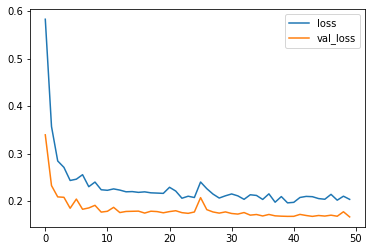

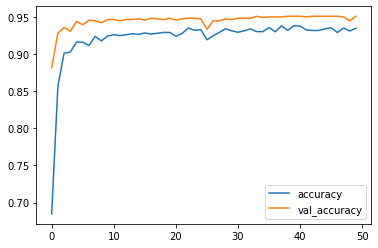

In [16]:
y_pred_one = np.argmax(model.predict(X_test), axis=1)
y_test_one = np.argmax(np.array(y_test), axis=1)

print_results(y_test_one, y_pred_one)
display_acc_hist(history)

##Conclusão

Para o estudo pegamos o modelo binário de classificação, para cogumelos venenosos ou não, pelas características físicas do fungo. Ao aplicar as técnicas de Hiperparâmetros, podemos verificar as diferenças entre o modelo anterior definidas manualmente, logo podemos notar que foi definido um valor maior de épocas de treinamento para o modelo, um número menor de neurônios no total, um learn rate menor. 

Os parâmetros mantiveram o mesmo valor de acurácia obtido do anterior, porém gastando menos recurso da maquina, porém levando muito mais tempo de processamento que o anterior, ja que para analisar quais seriam os melhores parâmetros, a pesquisa de melhores valores para hiperparâmetros levou 5 minutos. Entretanto o modelo quando executado pela segunda vez é possível perceber que não segue o mesmo tempo, pois o mesmo coleta os dados do arquivo que foi gerado na execução anterior após a análise dos valores.

Acredito que o modelo é uma boa opção inicial, usado para obter os primeiros parâmetros ao rodar a primeira vez. Com o amadurecimento do modelo, da base de treino/teste e das diretrizes do uso, os valores dos parâmetros podem ser coletados e refinados manualmente para melhor se adequar ao case.